# 卷积运算(Convolution)

- 核 == 过滤器
- 填充(padding)
- 步幅(stride)

## 计算输出大小
- Input: (H, W)
- Filter: (FH, FW)
- Padding: P
- Stride: S
- Output: (OH, HW)

`
OH = (H + 2 * P - FH) / S +1
OW = (W + 2 * P - FW) / S +1
`

## 三维数据的卷积运算

(Channel, Width, Height)

(C, FH, FW)

多个滤波器: (FN, C, FH, FW)
输出数据: (FN, OH, OW)

### 批处理
(N, C, H, W) * (FN, C, H, W) -> (N, FN, OH, OW) + (FN, 1, 1) -> (N, FN, OH, OW)

1. N个C通道的图像(H, W)
2. FN个C通道的过滤器
3. N个FN个输出(OH, OW)
4. N个偏置
5. N个FN个输出(OH, OW)

## 池化层(Polling)

Max池化
1. 没有要学习的参数
2. 通道数不变

# 卷积层和池化层的实现

In [3]:
# 4维数组
import numpy as np

# 10个通道为1的28x28的图像
x = np.random.rand(10, 1, 28, 28)
x.shape

(10, 1, 28, 28)

In [6]:
x[0, 0].shape

(28, 28)

## 基于im2col的展开

In [18]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    input_data : 由(数据量, 通道, 高, 长)的4维数组构成的输入数据
    filter_h : 滤波器的高
    filter_w : 滤波器的长
    stride : 步幅
    pad : 填充

    Returns
    -------
    col : 2维数组
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    col :
    input_shape : 输入数据的形状（例：(10, 1, 28, 28)）
    filter_h :
    filter_w
    stride
    pad

    Returns
    -------

    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

In [19]:
x1 = np.random.rand(1, 3, 7, 7)
print(x1.shape, np.sum(x1.shape))
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape, np.sum(col1.shape))
print(np.sum(col1.shape) / np.sum(x1.shape))

(1, 3, 7, 7) 18
(9, 75) 84
4.666666666666667


In [20]:
x1 = np.random.rand(10, 3, 7, 7)
print(x1.shape, np.sum(x1.shape))
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape, np.sum(col1.shape))

(10, 3, 7, 7) 27
(90, 75) 165


In [23]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 中间数据（backward时使用）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 权重和偏置参数的梯度
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx

In [24]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

In [25]:
import sys, os
sys.path.append('SourceCode')  # 为了导入父目录的文件而进行的设定
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient
class SimpleConvNet:
    """简单的ConvNet

    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 输入大小（MNIST的情况下为784）
    hidden_size_list : 隐藏层的神经元数量的列表（e.g. [100, 100, 100]）
    output_size : 输出大小（MNIST的情况下为10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 指定权重的标准差（e.g. 0.01）
        指定'relu'或'he'的情况下设定“He的初始值”
        指定'sigmoid'或'xavier'的情况下设定“Xavier的初始值”
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, 
                 output_size=10, 
                 weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 初始化权重
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 生成层
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """求损失函数
        参数x是输入数据、t是教师标签
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """求梯度（数值微分）

        Parameters
        ----------
        x : 输入数据
        t : 教师标签

        Returns
        -------
        具有各层的梯度的字典变量
            grads['W1']、grads['W2']、...是各层的权重
            grads['b1']、grads['b2']、...是各层的偏置
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """求梯度（误差反向传播法）

        Parameters
        ----------
        x : 输入数据
        t : 教师标签

        Returns
        -------
        具有各层的梯度的字典变量
            grads['W1']、grads['W2']、...是各层的权重
            grads['b1']、grads['b2']、...是各层的偏置
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 设定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

train loss:2.300075529498667
=== epoch:1, train acc:0.347, test acc:0.337 ===
train loss:2.2976231914909446
train loss:2.293250345791921
train loss:2.28822831593672
train loss:2.2762179142640155
train loss:2.265384329176502
train loss:2.2453830639417514
train loss:2.228250896762913
train loss:2.1989768105260565
train loss:2.176146614587384
train loss:2.1419209883940895
train loss:2.074808727553951
train loss:2.074019128883002
train loss:1.9838108076872403
train loss:1.9608504263287967
train loss:1.919767377149119
train loss:1.8410096651218897
train loss:1.7592103904482619
train loss:1.660917894109475
train loss:1.588977979748135
train loss:1.4210663365184073
train loss:1.4098360773421894
train loss:1.2970590994056093
train loss:1.2402570655156981
train loss:1.1300891593411497
train loss:1.0777503744516785
train loss:0.9311281388455438
train loss:0.8127188006375071
train loss:0.9160272699717268
train loss:0.8165279445500923
train loss:0.7648235894645693
train loss:0.6928373004195139
tra

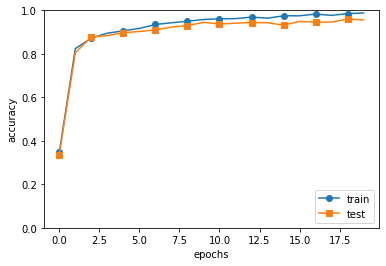

In [26]:
import sys, os
sys.path.append('SourceCode')  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.trainer import Trainer

# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 处理花费时间较长的情况下减少数据 
x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 保存参数
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 绘制图形
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


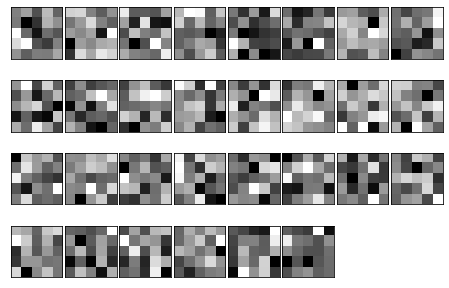

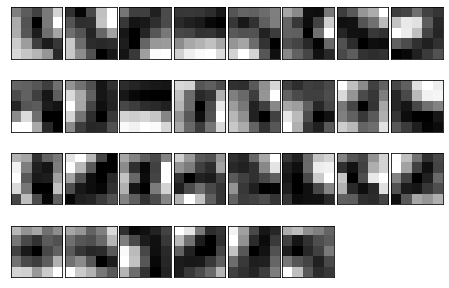

In [28]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('SourceCode')

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# 随机进行初始化后的权重
filter_show(network.params['W1'])

# 学习后的权重
network.load_params("params.pkl")
filter_show(network.params['W1'])